In [1]:
import os
import time
import torch
import pickle
import numpy as np
import pandas as pd
from bt.data import *
import torch.nn as nn
from bt.models import *
from bt.utils import *
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from torchvision.models import inception_v3, resnet50, vgg16, vgg16_bn

In [2]:
batch_size = 32

n_classes = 3

epochs = 1

lr = 3e-4

num_workers = 4

image_size = (224, 224)

class_names = ['Glioma', 'Meningioma', 'Pituitary']

images_dir = 'data/'
model_dir = 'models/'

os.makedirs(model_dir, exist_ok=True)

df = pd.DataFrame(columns=['model', 'accuracy', 'loss', 'precision_class_wise', 'precision_avg', 'recall_class_wise', 'recall_avg', 'f1_class_wise', 'f1_avg'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [3]:
dataset = ImageFolder(root=images_dir)

In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=101) 

FOLD 1


Training the model
Epoch:  1  batch:      1 [     1/77]  Loss: 1.127039  Accuracy: 53.125000%
Epoch:  1  batch:      3 [     3/77]  Loss: 1.376617  Accuracy: 48.958333%
Epoch:  1  batch:      5 [     5/77]  Loss: 1.302411  Accuracy: 51.875000%
Epoch:  1  batch:      7 [     7/77]  Loss: 1.027431  Accuracy: 52.678571%
Epoch:  1  batch:      9 [     9/77]  Loss: 0.863523  Accuracy: 54.166667%
Epoch:  1  batch:     11 [    11/77]  Loss: 0.753767  Accuracy: 57.386364%
Epoch:  1  batch:     13 [    13/77]  Loss: 1.042505  Accuracy: 59.134615%
Epoch:  1  batch:     15 [    15/77]  Loss: 0.835389  Accuracy: 60.000000%
Epoch:  1  batch:     17 [    17/77]  Loss: 0.688325  Accuracy: 61.213235%
Epoch:  1  batch:     19 [    19/77]  Loss: 0.829565  Accuracy: 62.335526%
Epoch:  1  batch:     21 [    21/77]  Loss: 0.648516  Accuracy: 62.648810%
Epoch:  1  batch:     23 [    23/77]  Loss: 0.929497  Accuracy: 62.907609%
Epoch:  1  batch:     25 [    25/77]  Loss: 0.905141  Accuracy: 63.75000

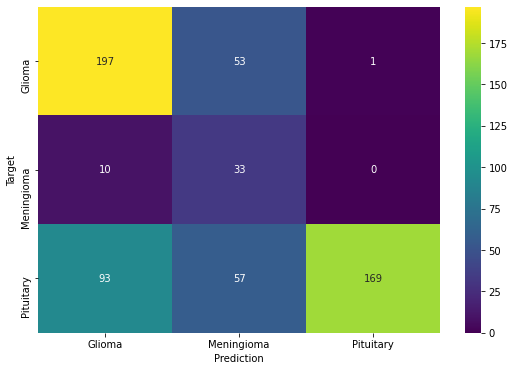


Accuracy Score: 0.6509

Classification Report: 

              precision    recall  f1-score   support

         0.0       0.66      0.78      0.72       251
         1.0       0.23      0.77      0.35        43
         2.0       0.99      0.53      0.69       319

    accuracy                           0.65       613
   macro avg       0.63      0.69      0.59       613
weighted avg       0.80      0.65      0.68       613


Precision Score (Class-Wise): 
[0.65666667 0.23076923 0.99411765]
Average Precision Score: 0.6271845148315737

Recall Score (Class-Wise): 
[0.78486056 0.76744186 0.52978056]
Average Recall Score: 0.6940276608324544

F1 Score (Class-Wise): 
[0.71506352 0.35483871 0.69120654]
Average F1: 0.5870362581719477

Finished Training

Training Duration 0.64 minutes
GPU memory used : 386715648 kb
GPU memory cached : 1572864000 kb


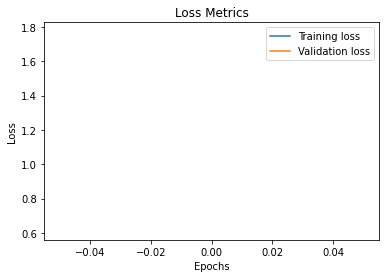

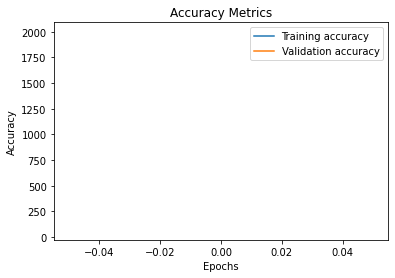

FOLD 2


Training the model
Epoch:  1  batch:      1 [     1/77]  Loss: 1.476801  Accuracy: 25.000000%
Epoch:  1  batch:      3 [     3/77]  Loss: 1.275000  Accuracy: 37.500000%
Epoch:  1  batch:      5 [     5/77]  Loss: 1.468804  Accuracy: 41.250000%
Epoch:  1  batch:      7 [     7/77]  Loss: 0.991056  Accuracy: 42.857143%
Epoch:  1  batch:      9 [     9/77]  Loss: 0.750562  Accuracy: 49.305556%


KeyboardInterrupt: 

In [5]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold+1}\n')
    
    model_name = f'resnet50_wo_aug_fold_{fold}' 
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler, collate_fn=plain_transform)

    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler, collate_fn=plain_transform)
    
    model = resnet50()

    model.fc = nn.Linear(model.fc.in_features, 3)
    
    model = model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print('\nTraining the model')
    b, test_b = 0, 0

    training_losses = []
    training_accuracies = []
    test_loss = []
    test_corr = []

    start_time = time.time()

    for epoch in range(epochs):
        e_start = time.time()

        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        tst_corr = 0.0

        for b, (X_train, y_train) in enumerate(trainloader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(X_train)
            
            y_pred = y_pred.view(-1, n_classes)
            
            loss = criterion(y_pred, y_train)

            predicted = torch.argmax(y_pred.data, dim=1).data
            batch_corr = (predicted == y_train).sum()
            running_accuracy += batch_corr
            
            loss.backward()
            
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()

            if b % int(len(trainloader)/batch_size) == 0:
                print(f'Epoch: {epoch+1:2}  batch: {b+1:6} [{b+1:6}/{len(trainloader)}]  Loss: {loss.item():.6f}  Accuracy: {running_accuracy.item()*100/((batch_size) * (b+1)):.6f}%')
            
        training_losses.append(loss.item())
        training_accuracies.append(running_accuracy.item()*100/((batch_size) * (b+1)))

        print(f"Epoch {epoch+1} | Training Accuracy: {training_accuracies[-1]:.6f}% | Training Loss: {training_losses[-1]:.6f}")

        model.eval()
        b = 0

        with torch.no_grad():
            correct = 0
            labels = []
            pred = []

            new_y = 0.0

            # perform test set evaluation batch wise
            for b, (X, y) in enumerate(testloader):
                b += 1
                # set label to use CUDA if available
                X, y = X.to(device), y.to(device)
   
                labels.extend(y.view(-1).cpu().numpy())

                # perform forward pass
                y_val = model(X).view(-1, n_classes)

                # get argmax of predicted values, which is our label
                predicted = torch.argmax(y_val.data, dim=1).view(-1)

                # append predicted label
                pred.extend(predicted.cpu().numpy())

                # calculate loss
                loss = criterion(y_val, y)

                # increment correct with correcly predicted labels per batch
                correct += (predicted == y).sum()

            # append correct samples labels and losses
            test_corr.append(correct.item()*100/len(testloader))
            
            test_loss.append(loss.item())
                
        print(f"Test accuracy: {test_corr[-1]:.6f}% | Test Loss: {test_loss[-1]:.6f}")

        labels = torch.Tensor(labels)
        pred = torch.Tensor(pred)

    print("Test Metrics: \n")

    plot_confusion_matrix(pred, labels, class_names)

    a, p, p_avg, r, r_avg, f, f_avg = get_all_metrics(pred, labels)
    
    values = {'model': model_name, 'accuracy': a, 'loss': test_loss[-1], 'precision_class_wise': p, 'precision_avg': p_avg, 'recall_class_wise': r, 'recall_avg': r_avg, 'f1_class_wise': f, 'f1_avg': f_avg}
    df = df.append(values, ignore_index = True)

    print('Finished Training')

    end_time = time.time() - start_time    

    # print training summary
    print("\nTraining Duration {:.2f} minutes".format(end_time/60))
    print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
    print("GPU memory cached : {} kb".format(torch.cuda.memory_reserved()))

    plot_loss(training_losses, test_loss) 
    plot_accuracy(training_accuracies, test_corr) 

    torch.save(model.state_dict(), model_dir + '/' + model_name + f'_fold_{fold}.pt')
    df.to_csv('test_results.csv', index=False)

In [5]:
batch_size = 2 # generates 7 new images + original image - per image, 4 * 8 = 32 images per batch

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold+1}\n')
    
    model_name = f'resnet50_w_aug_fold_{fold}' 
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler, collate_fn=augmentor)

    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler, collate_fn=augmentor)
    
    testloader_plain = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler, collate_fn=plain_transform)
    
    model = resnet50()

    model.fc = nn.Linear(model.fc.in_features, 3)
    
    model = model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print('\nTraining the model')
    b, test_b = 0, 0

    training_losses = []
    training_accuracies = []
    test_loss = []
    test_corr = []

    start_time = time.time()

    for epoch in range(epochs):
        e_start = time.time()

        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        tst_corr = 0.0

        for b, (X_train, y_train) in enumerate(trainloader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(X_train)
            
            y_pred = y_pred.view(-1, n_classes)
            
            loss = criterion(y_pred, y_train)

            predicted = torch.argmax(y_pred.data, dim=1).data
            batch_corr = (predicted == y_train).sum()
            running_accuracy += batch_corr
            
            loss.backward()
            
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()

            if b % int(len(trainloader)/batch_size) == 0:
                print(f'Epoch: {epoch+1:2}  batch: {b+1:6} [{b+1:6}/{len(trainloader)}]  Loss: {loss.item():.6f}  Accuracy: {running_accuracy.item()*100/((batch_size * 8) * (b+1)):.6f}%')
            
        training_losses.append(loss.item())
        training_accuracies.append(running_accuracy.item()*100/((batch_size * 8) * (b+1)))

        print(f"Epoch {epoch+1} | Training Accuracy: {training_accuracies[-1]:.6f}% | Training Loss: {training_losses[-1]:.6f}")

        model.eval()
        b = 0

        with torch.no_grad():
            correct = 0
            labels = []
            pred = []

            new_y = 0.0

            # perform test set evaluation batch wise
            for b, (X, y) in enumerate(testloader):
                b += 1
                # set label to use CUDA if available
                X, y = X.to(device), y.to(device)
   
                labels.extend(y.view(-1).cpu().numpy())

                # perform forward pass
                y_val = model(X).view(-1, n_classes)

                # get argmax of predicted values, which is our label
                predicted = torch.argmax(y_val.data, dim=1).view(-1)

                # append predicted label
                pred.extend(predicted.cpu().numpy())

                # calculate loss
                loss = criterion(y_val, y)

                # increment correct with correcly predicted labels per batch
                correct += (predicted == y).sum()

            # append correct samples labels and losses
            test_corr.append(correct.item()*100/len(testloader))
            
            test_loss.append(loss.item())
                
        print(f"Test accuracy: {test_corr[-1]:.6f}% | Test Loss: {test_loss[-1]:.6f}")

        labels = torch.Tensor(labels)
        pred = torch.Tensor(pred)

    print("Test Metrics: \n")

    plot_confusion_matrix(pred, labels, class_names)

    a, p, p_avg, r, r_avg, f, f_avg = get_all_metrics(pred, labels)
    
    values = {'model': model_name, 'accuracy': a, 'loss': test_loss[-1], 'precision_class_wise': p, 'precision_avg': p_avg, 'recall_class_wise': r, 'recall_avg': r_avg, 'f1_class_wise': f, 'f1_avg': f_avg}
    df = df.append(values, ignore_index = True)

    print('Testing - without augmentation')
    
    with torch.no_grad():
        correct = 0
        labels = []
        pred = []

        new_y = 0.0

        # perform test set evaluation batch wise
        for b, (X, y) in enumerate(testloader_plain):
            b += 1
            # set label to use CUDA if available
            X, y = X.to(device), y.to(device)

            labels.extend(y.view(-1).cpu().numpy())

            # perform forward pass
            y_val = model(X).view(-1, n_classes)

            # get argmax of predicted values, which is our label
            predicted = torch.argmax(y_val.data, dim=1).view(-1)

            # append predicted label
            pred.extend(predicted.cpu().numpy())

            # calculate loss
            loss = criterion(y_val, y)

            # increment correct with correcly predicted labels per batch
            correct += (predicted == y).sum()

        # append correct samples labels and losses
        test_corr.append(correct.item()*100/len(testloader_plain))

        test_loss.append(loss.item())

    print(f"Test accuracy: {test_corr[-1]:.6f}% | Test Loss: {test_loss[-1]:.6f}")

    labels = torch.Tensor(labels)
    pred = torch.Tensor(pred)
    
    print("Test Metrics: \n")

    plot_confusion_matrix(pred, labels, class_names)

    a, p, p_avg, r, r_avg, f, f_avg = get_all_metrics(pred, labels)
    
    values = {'model': model_name + '_test_plain', 'accuracy': a, 'loss': test_loss[-1], 'precision_class_wise': p, 'precision_avg': p_avg, 'recall_class_wise': r, 'recall_avg': r_avg, 'f1_class_wise': f, 'f1_avg': f_avg}
    df = df.append(values, ignore_index = True)
    
    print('Finished Training')

    end_time = time.time() - start_time    

    # print training summary
    print("\nTraining Duration {:.2f} minutes".format(end_time/60))
    print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
    print("GPU memory cached : {} kb".format(torch.cuda.memory_reserved()))

    plot_loss(training_losses, test_loss) 
    plot_accuracy(training_accuracies, test_corr) 

    torch.save(model.state_dict(), model_dir + '/' + model_name + f'_fold_{fold}.pt')
    df.to_csv('test_results.csv', index=False)

FOLD 1


Training the model
Epoch:  1  batch:      1 [     1/1226]  Loss: 0.800937  Accuracy: 50.000000%


KeyboardInterrupt: 

In [ ]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold+1}\n')
    
    model_name = f'resnet50_frozen_wo_aug_fold_{fold}' 
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler, collate_fn=plain_transform)

    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler, collate_fn=plain_transform)
    
    model = resnet50()
    
    for params in model.parameters():
        params.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, 3)
    
    for params in model.fc.parameters():
        params.requires_grad = True
    
    model = model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print('\nTraining the model')
    b, test_b = 0, 0

    training_losses = []
    training_accuracies = []
    test_loss = []
    test_corr = []

    start_time = time.time()

    for epoch in range(epochs):
        e_start = time.time()

        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        tst_corr = 0.0

        for b, (X_train, y_train) in enumerate(trainloader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(X_train)
            
            y_pred = y_pred.view(-1, n_classes)
            
            loss = criterion(y_pred, y_train)

            predicted = torch.argmax(y_pred.data, dim=1).data
            batch_corr = (predicted == y_train).sum()
            running_accuracy += batch_corr
            
            loss.backward()
            
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()

            if b % int(len(trainloader)/batch_size) == 0:
                print(f'Epoch: {epoch+1:2}  batch: {b+1:6} [{b+1:6}/{len(trainloader)}]  Loss: {loss.item():.6f}  Accuracy: {running_accuracy.item()*100/((batch_size) * (b+1)):.6f}%')
            
        training_losses.append(loss.item())
        training_accuracies.append(running_accuracy.item()*100/((batch_size) * (b+1)))

        print(f"Epoch {epoch+1} | Training Accuracy: {training_accuracies[-1]:.6f}% | Training Loss: {training_losses[-1]:.6f}")

        model.eval()
        b = 0

        with torch.no_grad():
            correct = 0
            labels = []
            pred = []

            new_y = 0.0

            # perform test set evaluation batch wise
            for b, (X, y) in enumerate(testloader):
                b += 1
                # set label to use CUDA if available
                X, y = X.to(device), y.to(device)
   
                labels.extend(y.view(-1).cpu().numpy())

                # perform forward pass
                y_val = model(X).view(-1, n_classes)

                # get argmax of predicted values, which is our label
                predicted = torch.argmax(y_val.data, dim=1).view(-1)

                # append predicted label
                pred.extend(predicted.cpu().numpy())

                # calculate loss
                loss = criterion(y_val, y)

                # increment correct with correcly predicted labels per batch
                correct += (predicted == y).sum()

            # append correct samples labels and losses
            test_corr.append(correct.item()*100/len(testloader))
            
            test_loss.append(loss.item())
                
        print(f"Test accuracy: {test_corr[-1]:.6f}% | Test Loss: {test_loss[-1]:.6f}")

        labels = torch.Tensor(labels)
        pred = torch.Tensor(pred)

    print("Test Metrics: \n")

    plot_confusion_matrix(pred, labels, class_names)

    a, p, p_avg, r, r_avg, f, f_avg = get_all_metrics(pred, labels)
    
    values = {'model': model_name, 'accuracy': a, 'loss': test_loss[-1], 'precision_class_wise': p, 'precision_avg': p_avg, 'recall_class_wise': r, 'recall_avg': r_avg, 'f1_class_wise': f, 'f1_avg': f_avg}
    df = df.append(values, ignore_index = True)

    print('Finished Training')

    end_time = time.time() - start_time    

    # print training summary
    print("\nTraining Duration {:.2f} minutes".format(end_time/60))
    print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
    print("GPU memory cached : {} kb".format(torch.cuda.memory_reserved()))

    plot_loss(training_losses, test_loss) 
    plot_accuracy(training_accuracies, test_corr) 

    torch.save(model.state_dict(), model_dir + '/' + model_name + f'_fold_{fold}.pt')
    df.to_csv('test_results.csv', index=False)

In [ ]:
batch_size = 2 # generates 7 new images + original image - per image, 4 * 8 = 32 images per batch

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold+1}\n')
    
    model_name = f'resnet50_frozen_w_aug_fold_{fold}' 
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler, collate_fn=augmentor)

    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler, collate_fn=augmentor)
    
    testloader_plain = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler, collate_fn=plain_transform)
    
    model = resnet50()

    for params in model.parameters():
        params.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, 3)
    
    for params in model.fc.parameters():
        params.requires_grad = True
    
    model = model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print('\nTraining the model')
    b, test_b = 0, 0

    training_losses = []
    training_accuracies = []
    test_loss = []
    test_corr = []

    start_time = time.time()

    for epoch in range(epochs):
        e_start = time.time()

        model.train()

        running_loss = 0.0
        running_accuracy = 0.0
        tst_corr = 0.0

        for b, (X_train, y_train) in enumerate(trainloader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(X_train)
            
            y_pred = y_pred.view(-1, n_classes)
            
            loss = criterion(y_pred, y_train)

            predicted = torch.argmax(y_pred.data, dim=1).data
            batch_corr = (predicted == y_train).sum()
            running_accuracy += batch_corr
            
            loss.backward()
            
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()

            if b % int(len(trainloader)/batch_size) == 0:
                print(f'Epoch: {epoch+1:2}  batch: {b+1:6} [{b+1:6}/{len(trainloader)}]  Loss: {loss.item():.6f}  Accuracy: {running_accuracy.item()*100/((batch_size * 8) * (b+1)):.6f}%')
            
        training_losses.append(loss.item())
        training_accuracies.append(running_accuracy.item()*100/((batch_size * 8) * (b+1)))

        print(f"Epoch {epoch+1} | Training Accuracy: {training_accuracies[-1]:.6f}% | Training Loss: {training_losses[-1]:.6f}")

        model.eval()
        b = 0

        with torch.no_grad():
            correct = 0
            labels = []
            pred = []

            new_y = 0.0

            # perform test set evaluation batch wise
            for b, (X, y) in enumerate(testloader):
                b += 1
                # set label to use CUDA if available
                X, y = X.to(device), y.to(device)
   
                labels.extend(y.view(-1).cpu().numpy())

                # perform forward pass
                y_val = model(X).view(-1, n_classes)

                # get argmax of predicted values, which is our label
                predicted = torch.argmax(y_val.data, dim=1).view(-1)

                # append predicted label
                pred.extend(predicted.cpu().numpy())

                # calculate loss
                loss = criterion(y_val, y)

                # increment correct with correcly predicted labels per batch
                correct += (predicted == y).sum()

            # append correct samples labels and losses
            test_corr.append(correct.item()*100/len(testloader))
            
            test_loss.append(loss.item())
                
        print(f"Test accuracy: {test_corr[-1]:.6f}% | Test Loss: {test_loss[-1]:.6f}")

        labels = torch.Tensor(labels)
        pred = torch.Tensor(pred)

    print("Test Metrics (With test set augmentation): \n")

    plot_confusion_matrix(pred, labels, class_names)

    a, p, p_avg, r, r_avg, f, f_avg = get_all_metrics(pred, labels)
    
    values = {'model': model_name, 'accuracy': a, 'loss': test_loss[-1], 'precision_class_wise': p, 'precision_avg': p_avg, 'recall_class_wise': r, 'recall_avg': r_avg, 'f1_class_wise': f, 'f1_avg': f_avg}
    df = df.append(values, ignore_index = True)
    
    with torch.no_grad():
        correct = 0
        labels = []
        pred = []

        new_y = 0.0

        # perform test set evaluation batch wise
        for b, (X, y) in enumerate(testloader_plain):
            b += 1
            # set label to use CUDA if available
            X, y = X.to(device), y.to(device)

            labels.extend(y.view(-1).cpu().numpy())

            # perform forward pass
            y_val = model(X).view(-1, n_classes)

            # get argmax of predicted values, which is our label
            predicted = torch.argmax(y_val.data, dim=1).view(-1)

            # append predicted label
            pred.extend(predicted.cpu().numpy())

            # calculate loss
            loss = criterion(y_val, y)

            # increment correct with correcly predicted labels per batch
            correct += (predicted == y).sum()

        # append correct samples labels and losses
        test_corr.append(correct.item()*100/len(testloader_plain))

        test_loss.append(loss.item())

    print(f"Test accuracy: {test_corr[-1]:.6f}% | Test Loss: {test_loss[-1]:.6f}")

    labels = torch.Tensor(labels)
    pred = torch.Tensor(pred)
    
    print("Test Metrics (Without test set augmentation): \n")

    plot_confusion_matrix(pred, labels, class_names)

    a, p, p_avg, r, r_avg, f, f_avg = get_all_metrics(pred, labels)
    
    values = {'model': model_name + '_test_plain', 'accuracy': a, 'loss': test_loss[-1], 'precision_class_wise': p, 'precision_avg': p_avg, 'recall_class_wise': r, 'recall_avg': r_avg, 'f1_class_wise': f, 'f1_avg': f_avg}
    df = df.append(values, ignore_index = True)
    
    print('Finished Training')

    end_time = time.time() - start_time    

    # print training summary
    print("\nTraining Duration {:.2f} minutes".format(end_time/60))
    print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
    print("GPU memory cached : {} kb".format(torch.cuda.memory_reserved()))

    plot_loss(training_losses, test_loss) 
    plot_accuracy(training_accuracies, test_corr) 

    torch.save(model.state_dict(), model_dir + '/' + model_name + f'_fold_{fold}.pt')
    df.to_csv('test_results.csv', index=False)